In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# In[ ]:


class Layer:
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

    def update(self, learn_rate):
        """Perform weight update based on previously stored input and gradients.

        Args:
            learn_rate: Learn rate to use for the update.
        """


# In[ ]:


class LinearLayer(Layer):
    def __init__(self, input_dim, output_dim, seed=None):
        # Initialize weights with the He initializer
        rnd = np.random.RandomState(seed).randn(input_dim, output_dim)
        self.w = rnd * (2 / input_dim)

        # Initialize bias with zeros
        self.b = np.zeros(output_dim)

    def forward(self, x):
        # Forward pass of the layer
        self.input = x
        x = np.dot(x, self.w) + self.b
        self.output = x
        return x

    def backward(self, gradient):
        # Backward pass of the layer.
        self.gradient = gradient
        gradient = np.dot(gradient, self.w.T)
        return gradient

    def update(self, learn_rate):
        # Perform weight update
        self.w = self.w - learn_rate * np.dot(self.input.T, self.gradient)
        self.b = self.b - learn_rate * np.sum(self.gradient, axis=0)


# In[ ]:


class ReLULayer(Layer):
    def forward(self, x):
        # Forward pass of the ReLU layer
        self.input = x
        x = np.maximum(x, np.zeros_like(x))
        self.output = x
        return x

    def backward(self, gradient):
        # Backward pass of the ReLU layer
        self.gradient = gradient
        dy_dx = np.greater_equal(self.input, np.zeros_like(self.input)).astype(
            self.input.dtype
        )
        gradient = dy_dx * gradient
        return gradient


# In[ ]:


class SoftmaxLayer(Layer):
    def forward(self, x):
        # Forward pass of the softmax layer
        self.input = x
        x = np.exp(x - np.max(x, axis=-1))
        return x / np.sum(x, axis=-1)
        self.output = x
        return x

In [5]:
class FeedForwardNet:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # Forward pass through the entire network.
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, gradient):
        # Backward pass through the entire network

        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def train(self, x, target, learn_rate):
        # Train one batch
        gradient = self.forward(x) - target  # Assumes quadratic loss function
        self.backward(gradient)  # Backprop

        # Update weights in all layers
        for layer in self.layers:
            layer.update(learn_rate)

In [6]:
# In[ ]:


# AUTOENCODER on MNIST

import torch
import torchvision
from torchvision import transforms

# Load MNIST dataset
mnist = torchvision.datasets.MNIST(
    root="data/", download=True, transform=transforms.ToTensor()
)
mnist_test = np.array(
    [
        x.numpy()
        for x, y in torchvision.datasets.MNIST(
            root="data/", train=False, transform=transforms.ToTensor()
        )
    ]
).reshape(-1, 28, 28)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)


# In[ ]:


# Build autoencoder
autoencoder = FeedForwardNet(
    [
        LinearLayer(784, 400, seed=0),
        ReLULayer(),
        LinearLayer(400, 120, seed=1),
        ReLULayer(),
        LinearLayer(120, 16, seed=2),
        LinearLayer(16, 120, seed=3),
        ReLULayer(),
        LinearLayer(120, 400, seed=4),
        ReLULayer(),
        LinearLayer(400, 784, seed=5),
    ]
)

  0%|          | 0/14 [00:00<?, ?it/s]

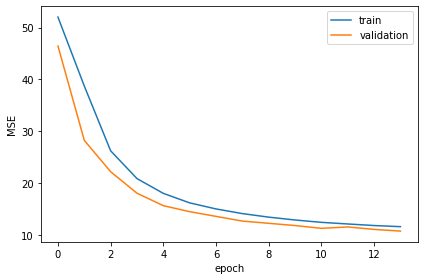

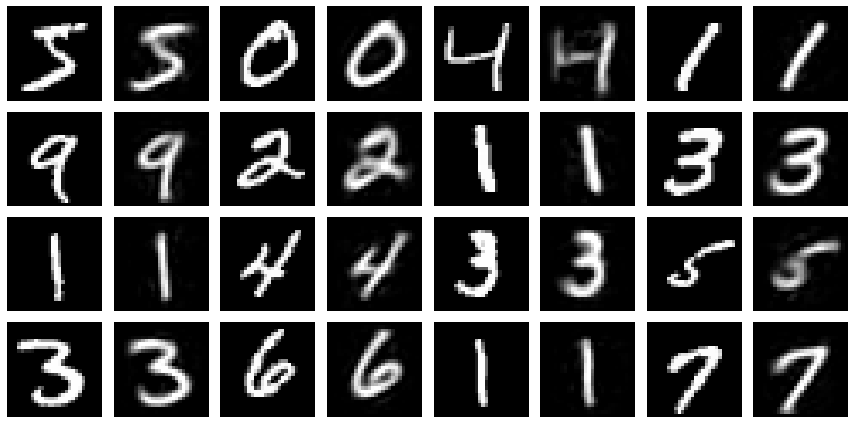

In [ ]:
# In[ ]:


# Training
epochs = 14

losses = np.empty((epochs, 2))
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:
        running_loss = 0.0
        for batch, _ in data_loader:
            batch = batch.reshape(batch.shape[0], -1).numpy()
            autoencoder.train(batch, batch, 0.001)

            running_loss += np.sum((autoencoder.layers[-1].output - batch) ** 2)

        # Log losses and update progress bar
        train_loss = running_loss / len(mnist)
        validation_loss = np.sum(
            np.mean(
                (
                    autoencoder.forward(mnist_test.reshape(-1, 28 * 28))
                    - mnist_test.reshape(-1, 28 * 28)
                )
                ** 2,
                axis=0,
            )
        )
        losses[epoch] = [train_loss, validation_loss]
        pbar.set_description(f"Loss {train_loss:.02f}/{validation_loss:.02f}")


# Visualize losses
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:, 0], label="train")
plt.plot(np.arange(len(losses)), losses[:, 1], label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.tight_layout()


# In[ ]:


# Reconstruction
plt.figure(figsize=(12, 6))
for i in range(16):
    # Show image
    plt.subplot(4, 8, 2 * i + 1)
    plt.imshow(mnist[i][0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    # Show reconstruction
    plt.subplot(4, 8, 2 * i + 2)
    plt.imshow(
        autoencoder.forward(mnist[i][0].reshape(28 * 28)).reshape(28, 28),
        cmap="gray",
        vmin=0,
        vmax=1,
    )
    plt.axis("off")
plt.tight_layout()


# In[ ]:


# Interpolation
encoder = FeedForwardNet(autoencoder.layers[:5])
decoder = FeedForwardNet(autoencoder.layers[5:])

image_a = mnist[5][0]
image_b = mnist[4][0]

# Computing latent representations
latent_a = encoder.forward(image_a.reshape(28 * 28))
latent_b = encoder.forward(image_b.reshape(28 * 28))


steps = 10
plt.figure(figsize=(16, 2))

for i, f in enumerate(np.linspace(0, 1, steps)):
    plt.subplot(1, steps, i + 1)
    latent = (1 - f) * latent_a + f * latent_b
    plt.imshow(decoder.forward(latent).reshape(28, 28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")

plt.tight_layout()


# In[ ]:


# Computing mean and std dev of latent states
latent_space = encoder.forward(mnist_test.reshape(-1, 28 * 28))
latent_space_mean = np.mean(latent_space, axis=0)
latent_space_std = np.std(latent_space, axis=0)

# Sampling from latent distribution
plt.figure(figsize=(16, 2))

for i, f in enumerate(np.linspace(0, 1, steps)):
    plt.subplot(1, steps, i + 1)
    latent = np.random.normal(latent_space_mean, latent_space_std, 16)

    plt.imshow(decoder.forward(latent).reshape(28, 28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()